In [1]:
# load the necessary functions
for (fnm in list.files("rwwa", full.names = T)) source(fnm)
library(extRemes)

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




# plot_covtrend when no event value is given

In [49]:
fit_ns <- function(dist, type = "fixeddisp", data, varnm, covnm = NA, lower = F, ev_year = NA, ev = NA, method = "BFGS") {

  # if no covariate name provided, add a dummy covariate & fit stationary series instead
  if(is.na(covnm[1])) {
    data <- cbind(data, "const" = 1)
    covnm <- "const"
  }

  # remove extraneous columns from dataframes
  cov <- data[, covnm, drop = F]
  k <- length(covnm)
  x <- data[,varnm]

  # should also add something to handle case with no covariates

  # currently only works for distributions fully specified by mean & sd: only tested for normal, lognormal
  if(! dist %in% c("norm", "gev")) {
    print("Not yet implemented: use norm or gev")
    return()
  }

  # if looking at lower tail with a GEV, necessary to negate data and consider block maxima - add flag to keep track
  minima <- F
  if (lower & (dist %in% c("gev"))) {
      x <- -x
      minima <- T
  }

  # fit model with appropriate number of parameters, pad if necessary
  init <- c("mu0" = mean(x), "sigma0" = sd(x), setNames(rep(0,k), paste0("alpha_", covnm)))

  if(type %in% c("shiftscale")) init <- c(init, setNames(rep(0,k), paste0("beta_", covnm)))

  if(dist %in% c("gev")) init <- c(init, "shape" = 0)
  fitted <- suppressWarnings(optim(par = init, ns_loglik, cov = cov, x = x, dist = dist, fittype = type, method = method))

  # if looking at lower tail with a GEV, necessary to flip data and consider block maxima, so trend & location parameters have been flipped. This may cause some confusion so may have to modify later!
  if(minima) {
    fitted[["NOTE"]] <- "NB: model parameters are estimated for negated values"
    fitted$par["mu0"] <- -fitted$par["mu0"]
    fitted$par[grepl("alpha", names(fitted$par))] <- -fitted$par[grepl("alpha", names(fitted$par))]
    x <- -x
  }

  # attach assorted useful information
  fitted[["dist"]] <- dist
  fitted[["type"]] <- type
  fitted[["varnm"]] <- varnm
  fitted[["covnm"]] <- covnm
  fitted[["data"]] <- data
  fitted[["x"]] <- x
  fitted[["cov"]] <- cov

  fitted[["lower"]] <- lower               # saves having to specify every time later on
  fitted[["minima"]] <- minima             # look at maxima of 0-temps, rather than minima of observed temps

  # event year: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
  if(is.na(ev_year)) { ev_year <- data$year[length(x)] }
  fitted[["ev_year"]] <- ev_year
    
  if (ev_year %in% data$year) {
        ev_idx <- which(data$year == ev_year)
      } else {
        ev_idx <- nrow(data)+1
      }
  
  # event value: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
  if(is.na(ev)) {
    if(ev_year %in% data$year) {
        ev <- data[data$year == ev_year,varnm]
      } else {
        print("WARNING: Event year not in data, no event value recorded")
        ev <- NA
      }
    }
  fitted[["ev"]] <- ev
  fitted[["ev_idx"]] <- ev_idx

  return(fitted)
}

In [57]:
plot_covtrend <- function(mdl, xcov, trend_cov = NA, ci_cov = NA,  ci_col = "black", ev, ev_x, rp = c(6,40), add_loess = F, loess_col = "forestgreen",
                          seed = 42, nsamp = 500, xlim = NA, ylim = NA, xlab = NA, ylab = NA, legend_pos = "topleft", main = "", lwd = 3) {

  if(is.na(xlab)) { xlab <- toupper(xcov)}
  if(is.na(ylab)) { ylab <- mdl$varnm}
  if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
  if(missing(ev)) { ev <- mdl$ev }

  x <- mdl$data[,xcov]
  if(missing(ev))    { ev <- mdl$ev }
  if(missing(ev_x)) { ev_x <- x[mdl$ev_idx] }
  o <- order(x)

  if(is.na(unlist(ci_cov)[1])) {
    # can't plot confidence intervals so set nsamp to NA
    nsamp <- NA
    xlims <- range(x)
  } else {
    # extend the x-axis to accommodate the CI covariates
    xlims <- range(pretty(c(ci_cov[,xcov], x)))

    # if only the x-covariate is provided, set the other covariates to the mean value for plotting
    for(cnm in mdl$covnm) {
      if(!cnm %in% colnames(ci_cov)) ci_cov[,cnm] <- mean(mdl$data[,cnm])
    }
  }
  if(is.na(unlist(xlim)[1])) xlim <- xlims

  if(is.na(unlist(trend_cov)[1])) {
    # if no plotting covariate provided, fix all covariates at mean value except for xcov
    trend_cov <- data.frame(sapply(mdl$covnm, function(cnm) if(cnm == xcov) {mdl$data[,cnm]} else {mean(mdl$data[,cnm])}, simplify = F))
  }

  # set up legend
  legend_labels = "Fitted value"
  legend_cols = "black"
  legend_lty = "solid"
  legend_lwd = lwd

  # modify legend if adding effective return levels
  rp <- unique(rp[!is.na(rp)])
  if(length(rp) > 0) {
    legend_labels = c(legend_labels, paste0("1-in-",rp,"-year event"))
    legend_cols = c(legend_cols, rep("blue",length(rp)))
    legend_lty = c(legend_lty, rep("solid",length(rp)))
    legend_lwd = c(legend_lwd,c(lwd,max(1,lwd -1))[1:length(rp)])
  }

  plot(x, mdl$x, pch = 20, main = main, xlab = "", ylab = "", ylim = ylim, xlim = xlim,
       col = adjustcolor("black", 0.6))
  mtext(xlab, side = 1, line = 2.5, cex = par("cex.lab"))
  mtext(ylab, side = 2, line = 2.5, cex = par("cex.lab"))

  points(ev_x, ev, col = "magenta", lwd = 2, pch = 0)

  # trend lines
  lines(x[o], ns_pars(mdl, fixed_cov = trend_cov)$loc[o], lwd = 3, col = "black", lty = 1)
  lines(x[o], eff_return_level(mdl, rp[1], fixed_cov = trend_cov)[o], col = "blue", lwd = 3, lty = 1)
  lines(x[o], eff_return_level(mdl, rp[2], fixed_cov = trend_cov)[o], col = "blue", lwd = 2, lty = 1)

  # get confidence interval for mu' (if not required, set ci_cov to NA)
  if(!is.na(nsamp)) {
    mdl_df <- mdl$data
    set.seed(seed)
    mu_ci <- apply(sapply(1:nsamp, function(i) {
      boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
      tryCatch({
        boot_mdl <- refit(mdl, boot_df)
        sapply(rownames(ci_cov), function(rnm) ns_pars(boot_mdl, ci_cov[rnm,,drop = F])$loc)
      }, error = function(cond) {return(rep(NA, nrow(ci_cov)))})
    }), 1, quantile, c(0.025, 0.975), na.rm = T)

    # confidence interval & markers for mu' at factual & counterfactual covariates
    segments(x0 = ci_cov[,xcov], y0 = mu_ci["2.5%",], y1 = mu_ci["97.5%",], lwd = 3, col = ci_col, lend = 1)
    # matplot(ci_cov[,"gmst"], t(mu_ci), pch = 3, add = T, col = "red3") # line ends: not very elegant, so removed for now
    points(ci_cov[,xcov], sapply(rownames(ci_cov), function(rnm) ns_pars(mdl, ci_cov[rnm,,drop = F])$loc), pch = "_", col = ci_col, lwd = 2)
  }

  # add a loess smoother
  if(add_loess) {
    dfx <- mdl$data[order(mdl$data[,xcov]),]
    lines(dfx[,xcov], fitted(loess(formula(paste0(mdl$varnm," ~ ", xcov)), dfx)), col = loess_col, lwd = lwd, lty = "22")
    legend_labels <- c(legend_labels, "Loess smoothed")
    legend_cols <- c(legend_cols, loess_col)
    legend_lty <- c(legend_lty, "22")
    legend_lwd <- c(legend_lwd, lwd)
  }

  # add legend
  legend(legend_pos, legend = legend_labels, lty = legend_lty, col = legend_cols, lwd = legend_lwd, cex = par()$cex.lab)
}

                                 
                                 

In [58]:
df <- merge(read.table("gmst.dat", col.names = c("year", "gmst")), read.table("era5_spi-ond_data.dat", header = T))

In [59]:
mdl <- fit_ns("norm", "shift", data = df, varnm = "spi_ond", covnm = "gmst", lower = T, ev_year = 2025, ev = 1)

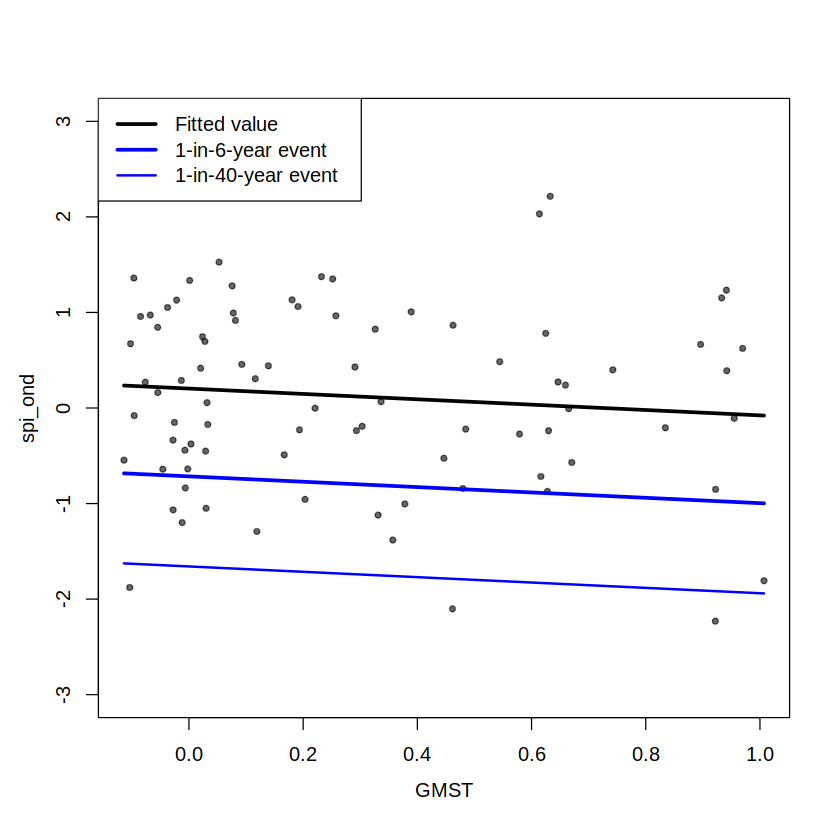

In [60]:
plot_covtrend(mdl, "gmst")

In [ ]:
z